In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()  

[PyTorch Tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

- Transfer Learning을 이용해 Network를 학습하는 방법에 작성된 글입니다
- 충분한 크기의 데이터 세트를 갖긴 힘들기 때문에 잘 학습된 네트워크를 Pretrain한 후 사용하는 경우가 많음

- convnet finetuning : 무작위 초기화 대신 imagenet 1000 데이터셋에서 학습한 네트워크를 사용해 네트워크 초기화하고 훈련은 동일하게 진행
- 고정된 Feature 추출 : 최종 Fully Connected Layer를 제외한 모든 네트워크의 가중치를 고정. 마지막 레이어는 새 레이어로 대체되고 이 레이어만 학습

- ants와 bees를 분류하는 모델을 만들려고 합니다. 각 클래스별 120개의 이미지가 있고, 75개의 validation 데이터가 있습니다. 굉장히 작은 데이터지만 transfer learning을 통해 합리적으로 만들어보겠습니다

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

/usr/local/lib/python3.6/site-packages/torchvision/transforms/transforms.py:397: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")
/usr/local/lib/python3.6/site-packages/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [7]:
data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

# 시각화 

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # 데이터를 numpy 객체로 바꾼 후 Transpose
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [9]:
# Get a batch of training data
# dataloaders의 객체는 iterable함
inputs, classes = next(iter(dataloaders['train']))

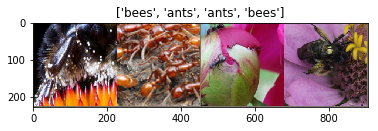

In [12]:
# Make a grid from batch
'''
torchvision.utils.make_grid(tensor, nrow=8, padding=2, normalize=False, range=None, scale_each=False, pad_value=0)
이미지의 그리드를 만드는 함수

Args:
    tensor (Tensor or list): 4D mini-batch Tensor of shape (B x C x H x W)
        or a list of images all of the same size.
    nrow (int, optional): Number of images displayed in each row of the grid.
        The Final grid size is (B / nrow, nrow). Default is 8.
    padding (int, optional): amount of padding. Default is 2.
    normalize (bool, optional): If True, shift the image to the range (0, 1),
        by subtracting the minimum and dividing by the maximum pixel value.
    range (tuple, optional): tuple (min, max) where min and max are numbers,
        then these numbers are used to normalize the image. By default, min and max
        are computed from the tensor.
    scale_each (bool, optional): If True, scale each image in the batch of
        images separately rather than the (min, max) over all images.
    pad_value (float, optional): Value for the padded pixels.
'''
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [13]:
class_names

['ants', 'bees']

In [14]:
classes


 1
 0
 0
 1
[torch.LongTensor of size 4]

- learning rate를 스케쥴링
- 가장 좋은 Model을 저장

In [34]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-'*10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True) # train
            else:
                model.eval()
                # model.train(False) # eval
            running_loss = 0.0
            running_corrects = 0
        
            for data in dataloaders[phase]:
                inputs, labels = data
                
                inputs, labels = Variable(inputs), Variable(labels)
                optimizer.zero_grad()
                
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1) #argmax
                loss = criterion(outputs, labels)
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
                

In [18]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()
    
    for i, data in enmerate(dataloaders['val']):
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        for j in range(inputs.size()[0]):
            image_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

# FineTuning

In [19]:
model_ft = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/kyle/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:04<00:00, 10896080.35it/s]


In [20]:
model_ft

ResNet(
  (conv1): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNo

In [22]:
type(model_ft)

torchvision.models.resnet.ResNet

In [25]:
dir(model_ft)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_all_buffers',
 '_apply',
 '_backend',
 '_backward_hooks',
 '_buffers',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_make_layer',
 '_modules',
 '_parameters',
 'add_module',
 'apply',
 'avgpool',
 'bn1',
 'children',
 'conv1',
 'cpu',
 'cuda',
 'double',
 'dump_patches',
 'eval',
 'fc',
 'float',
 'forward',
 'half',
 'inplanes',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'load_state_dict',
 'maxpool',
 'modules',
 'named_children',
 'named_modules',
 'named_parameters',
 'parameters',
 'register_backward_hook',
 'register_buffer',
 'register_forward_hook',
 'register_forwa

In [24]:
num_ftrs = model_ft.fc.in_features

In [26]:
num_ftrs

512

In [27]:
model_ft.fc = nn.Linear(num_ftrs, 2)

In [28]:
if use_gpu:
    model_ft = model_ft.cuda()

In [29]:
model_ft.parameters()

<generator object Module.parameters at 0x1060bea98>

In [30]:
[i for i in model_ft.parameters()]

[Parameter containing:
 (0 ,0 ,.,.) = 
  -1.0419e-02 -6.1356e-03 -1.8098e-03  ...   5.6615e-02  1.7083e-02 -1.2694e-02
   1.1083e-02  9.5276e-03 -1.0993e-01  ...  -2.7124e-01 -1.2907e-01  3.7424e-03
  -6.9434e-03  5.9089e-02  2.9548e-01  ...   5.1972e-01  2.5632e-01  6.3573e-02
                  ...                   ⋱                   ...                
  -2.7535e-02  1.6045e-02  7.2595e-02  ...  -3.3285e-01 -4.2058e-01 -2.5781e-01
   3.0613e-02  4.0960e-02  6.2850e-02  ...   4.1384e-01  3.9359e-01  1.6606e-01
  -1.3736e-02 -3.6746e-03 -2.4084e-02  ...  -1.5070e-01 -8.2230e-02 -5.7828e-03
 
 (0 ,1 ,.,.) = 
  -1.1397e-02 -2.6619e-02 -3.4641e-02  ...   3.2521e-02  6.6221e-04 -2.5743e-02
   4.5687e-02  3.3603e-02 -1.0453e-01  ...  -3.1253e-01 -1.6051e-01 -1.2826e-03
  -8.3730e-04  9.8420e-02  4.0210e-01  ...   7.0789e-01  3.6887e-01  1.2455e-01
                  ...                   ⋱                   ...                
  -5.5926e-02 -5.2239e-03  2.7081e-02  ...  -4.6178e-01 -5.7080

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [ ]:
%%time
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4143 Acc: 0.8115
val Loss: 0.3071 Acc: 0.8824
Epoch 1/24
----------
train Loss: 0.4749 Acc: 0.8238
val Loss: 0.2358 Acc: 0.9216
Epoch 2/24
----------
train Loss: 0.4017 Acc: 0.8238
val Loss: 0.4650 Acc: 0.8562
Epoch 3/24
----------
train Loss: 0.4429 Acc: 0.8279
val Loss: 0.2935 Acc: 0.9150
Epoch 4/24
----------
train Loss: 0.5350 Acc: 0.8033
val Loss: 0.3385 Acc: 0.9085
Epoch 5/24
----------
train Loss: 0.4534 Acc: 0.8320
val Loss: 0.3395 Acc: 0.8758
Epoch 6/24
----------
train Loss: 0.2927 Acc: 0.8730
val Loss: 0.2516 Acc: 0.9346
Epoch 7/24
----------
train Loss: 0.3242 Acc: 0.8648
val Loss: 0.2323 Acc: 0.9346
Epoch 8/24
----------
train Loss: 0.3141 Acc: 0.8730
val Loss: 0.2481 Acc: 0.9281
Epoch 9/24
----------
train Loss: 0.2950 Acc: 0.8811
val Loss: 0.2324 Acc: 0.9281
Epoch 10/24
----------
train Loss: 0.2746 Acc: 0.8689
val Loss: 0.2322 Acc: 0.9412
Epoch 11/24
----------


In [ ]:
#ToDO : tensorboardX를 사용해 loss떨어지는 것 구현하기

In [ ]:
visualize_model(model_ft)

# ConvNet as fixed feature extractor


- 마지막 레이러를 제외한 모든 네트워크를 freeze해야 합니다
- ```backward()```할 경우 계산이 되는 것을 방지하기 위해 ```requires_grad == False```를 해서 파라미터를 freeze해야합니다!
- [Autograd](http://pytorch.org/docs/master/notes/autograd.html) 문서 참고하기

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()